# Improving movie rating prediction

Question: How can we improve the movie rating prediction?
In the exploration part of the assignment, we intend to find ways to improve the rating prediction model. On the way of sharpening the prediction, we also prepared the dataset to subsets of test set and training set. We then use the test set to test to model trained by the training set. After that, we sharpened the model to better predict the movie rating. Therefore, the test is done twice—one for the original prediction, and another for the sharpened prediction. We then have the test results of the two for comparison. CSV files and the visualization of the findings will also be presented. 

## 1. Importing necessary libraries 

We used of a list of libraries that allows us to perform actions without spending extensive of time to write our own code. _pandas_ is used for loading and reading CSV tables, and matplotlib is used to visualize our findings.

In [3]:
from typing import TextIO, List, Union, Dict, Tuple
import doctest
from sentiment import *
from random import shuffle
import csv
import sys
import math

import pandas as pd
import matplotlib.pyplot as plt

## 2. Partitioning data into Test and training data
We split the given dataset into two subsets for testing and training with the ratio of 20 : 80. The ratio is custimizable by changing the test_size variable of partition_dataset function. The dataset is shuffled before the splitting to ensure the randomness of each sample. However, the ratio of the movie rating scores is kept representative of the population dataset.

In [4]:
def partition_dataset(file:TextIO, file_name:str, test_size:float) -> Dict:
    """Precondition: test_size > 0.0 and < 1.0 (one decimal)
    Create two datasets sorted randomly from the original. The test_dataset has the size
    requested in test_size, and the trainin_dataset has the remaining size.
    Print a message e.g., "The files: test_data.txt and training_data.txt were created",
    and return a dictionary e.g., {'test': 'test_data.txt', 'training': 'training_data.txt'}
    
    >>> file_names = partition_dataset(open('full.txt', 'r'), 'data', 0.2)
    The files: test_data.txt and training_data.txt were created
    >>> file_names
    {'test': 'test_data.txt', 'training': 'training_data.txt'}
    """
    all_reviews = file.readlines()
    shuffle(all_reviews)
    rating_counts = {}
    test_set = []
    training_set = []
    for review in all_reviews:
        if review[0] in rating_counts:
            rating_counts[review[0]].append(review)
        else:
            rating_counts[review[0]] = [review]
    for rating, reviews in rating_counts.items():
        length_of_test_data = round(len(reviews) * (test_size))
        test_set.extend(reviews[:length_of_test_data])
        training_set.extend(reviews[length_of_test_data:])
    test_file_name = "test_" + file_name + ".txt"
    training_file_name = "training_" + file_name + ".txt"

    with open(test_file_name, 'w') as test_file:
        for row in test_set:
            test_file.write(row)

    with open(training_file_name, 'w') as training_file:
        for row in training_set: 
            training_file.write(row)

    print('The files: '+ test_file_name + ' and ' + training_file_name + ' were created')
    return {'test':test_file_name, 'training':training_file_name}

## 3. Sharpening the model
In the many ways we have tried, we found that removing the given common words and neutral words improves the prediction model. We removed the common words from the kss dictionary because they may dilute the impact of more context specific words. [Why removing neutral words]

In [5]:
def sharpen_model(common_words_file:TextIO ,kss: Dict[str, List[int]])->Dict:
    """Sharpen the prediction model by removing neutral words and common words from kss dictionary. 
    Return kss_sharpened as the sharpened kss dictionary.
    """
    common_words_file = common_words_file.read().splitlines()
    kss_sharpened = {}
    for word, value in kss.items():
        if (judge(value[0]/value[1]) != 'neutral') or (word not in common_words_file):
            kss_sharpened[word] = value
    return kss_sharpened    

## 4. Get relevant numerical information
The following four functions gets four values that will be used to compare the the original prediction model and the sharpen prediction model. 

Predicted Sentiment Score: A sentiment of a statement(review) determined by the model.

Predicted Movie Rating: Because the PSS is ratio value and the movie rating is ordinal value, the predict_movie_rating will use the PSS score to predict a movie rating in ordinal value. 


The absolute difference: The absolute difference between PSS and the actual rating

If PSS is close enough to the actual rating: is_close_eval is another way to tell us if a PSS is considered close to the actual rating. Here, we put the threshold as 0.05. The values of the actual score and the PSS are considered closed if the difference is smaller than 0.05.

Then, report_errors will return a list of above four values for a review. Lastly, the report_mean_error function will return the mean error of all the errors between the actual scores and the predicted scores.

In [6]:
def predict_movie_rating(pss_score: float)->int:
    """ Get the Predicted Sentiment Score and use it to predict the movie rating from a review statement. 
    >>> predict_movie_rating(2.8)
    3
    >>> predict_movie_rating(1.2)
    1
    """
    return int(round(pss_score))

def is_close_eval(pss_score, actual_rating)-> bool:
    """ Get the difference between the actual movie rating and the Predicted Sentiment Score and determine
    if the difference is larger than 0.05. If the difference is larger than 0.05, return False. 
    If the difference is smaller than or equals to 0.05, return True.
    >>> is_close_eval(2.05, 2)
    True
    >>> is_close_eval(2.02, 2)
    True
    >>> is_close_eval(3.05, 2)
    False
    """
    return math.isclose(pss_score, actual_rating, abs_tol=0.05)

def report_errors(review: str, kss: Dict[str, List[int]])->List:
    """ Return a list of scores for each review in the follow order: 
    1. the Predicted Sentiment Score, 
    2. the predicted movie rating, 
    3. the absolute difference between PSS and the actual rating, 
    4. a boolean value returned by is_close_eval()
    """
    actual_rating = float(review[0])
    absolute_errors = []
    pss_score = statement_pss(review, kss)
    review_scores = []
    if pss_score != None:
        is_close_val = is_close_eval(pss_score, actual_rating)
        absolute_error = round((abs(float(pss_score) - actual_rating)), 2)
        absolute_errors.append(absolute_error)
        review_scores = [pss_score, predict_movie_rating(pss_score), absolute_error, is_close_val]
        return review_scores

def report_mean_error(absolute_errors:List[float]):
    """ Return the mean abosolute error of a given list of error values.
    >>> [1.56, 0.24, 0.69]
    0.83
    """
    if len(absolute_errors) != 0:
        mean_absolute_error = round(sum(absolute_errors)/len(absolute_errors), 5)
        return mean_absolute_error

## 5. Compare the models
After retrieving the four values for each model by the previous step, we can now use them to compare the original model and the sharpened model.

In [11]:
def compare_pss_models(test_file:TextIO, common_words_file:TextIO ,kss: Dict[str, List[int]], name_datasets) -> Dict:
    """Create a csv dataset with the comparison of the scores given by the kss model and the original ones. 
    Print the message "The file: reviews_comparison.csv was created" and return a dictionary with the 
    Mean_Absolute_Error(MAE) and Mean_Absolute_Error(MAE)_Sharpened of the dataset e.g., 
    {'Mean_Absolute_Error(MAE)': 1.00225, 'Mean_Absolute_Error(MAE)_Sharpened': 0.96186}
    >>> file1 = open('full.txt', 'r')
    >>> file2 = open('most_common_english_words.txt', 'r')
    >>> kss = extract_kss(file1)
    >>> testing_result = compare_pss_models(file1, file2, kss, 'data')
    The file: reviews_data.csv was created
    >>> file1.close()
    >>> file2.close()
    """
    scores_comparison = []
    original_report_list = []
    sharpened_report_list = []
    original_absolute_errors = []
    sharpened_absolute_errors = []
    test_reviews = test_file.readlines()
    
    ### Sharpend kss by removing all common words
    kss_sharpened = sharpen_model(common_words_file ,kss)
   
    # Iterate over each review in order to get predicted rating and MAE for kss and the sharpened version of kss          
    for review in test_reviews:
        statement = review[1:].strip()
        original_report = report_errors(review, kss)
        sharpened_report = report_errors(review, kss_sharpened)
        if statement_pss(review, kss) != None and statement_pss(review, kss_sharpened):
            original_report_list.append(original_report)
            sharpened_report_list.append(sharpened_report)
            original_absolute_errors.append(original_report[2])
            sharpened_absolute_errors.append(sharpened_report[2])
            scores_comparison.append([statement, review[0], 
                                      round(original_report[0],2), original_report[1], original_report[2], original_report[3], 
                                      round(sharpened_report[0],2), sharpened_report[1],sharpened_report[2], sharpened_report[3]])
            
    # Get mean absolute errors from the original and the sharpened model        
    mean_absolute_error = report_mean_error(original_absolute_errors)
    mean_absolute_error_sharpened = report_mean_error(sharpened_absolute_errors)

    # Save all reviews with their predicted scores and MAE using kss and kss_sharpened     
    with open('reviews_'+ name_datasets + '.csv', mode ='w') as comparison_file:
        comparison_writer = csv.writer(comparison_file, delimiter=",", quotechar='"', quoting = csv.QUOTE_MINIMAL)
        comparison_writer.writerow(["Mean Absolute Error(MAE): " + str(mean_absolute_error) ])
        comparison_writer.writerow(["Mean Absolute Error(MAE)   Sharpened: " + str(mean_absolute_error_sharpened) ])
        comparison_writer.writerow(["-","-","-","-","-"])
        comparison_writer.writerow(["Review", "Original Rating", 
                                    "PSS Score", "Predicted Rating", "Absolute Error", "Evaluation Result", 
                                    "PSS Score Sharpened", "Predicted Rating Sharpened","Absolute Error Sharpened", "Evaluation Result Sharpened"])
        for row in scores_comparison:
            comparison_writer.writerow(row)

    print('The file: ' + 'reviews_'+ name_datasets + '.csv' + ' was created')
    return {"Mean_Absolute_Error(MAE)": mean_absolute_error,"Mean_Absolute_Error(MAE)_Sharpened":mean_absolute_error_sharpened}

## 6. Open the files to execute the comparison

This function runs the test for more than one dataset and returns the Mean Absolute Error for each dataset as a dictionary

In [12]:
def execute_test(datasets: Dict[str, str], partition_size):
    """Precondition: the dictionary should have the form {name_dataset:dataset} e.g., {"small":"small.txt","medium":"medium.txt","full":"full.txt"}  
    Run compare_pss_models function for various datasets.
    """
    for name in datasets:
        with open(datasets[name], 'r') as file:
            file_names = partition_dataset(file, name, partition_size)
        with open(file_names['training'], 'r') as training_file:
                kss = extract_kss(training_file)  
        with open(file_names['test'], 'r') as test:
            with open(most_common_words) as common_words_file:
                testing_result = compare_pss_models(test, common_words_file, kss, name)

## 7. Testing the model


This code allows to assess the functions created and the KSS model

In [16]:
if __name__ == "__main__":
    #Create a dictionary containing diferent datasets, in order to compare accuracies among each other.
    datasets =  {
        "small"     : "small.txt",
        "medium"    : "medium.txt",
        "full"      : "full.txt"
    }        
    
    most_common_words = "most_common_english_words.txt"
    execute_test(datasets, 0.1)
    doctest.testmod()

FileNotFoundError: [Errno 2] No such file or directory: 'small.txt'

# Analysing the results

Before the analysis, we need to import our result datasets

In [10]:
evaluated_reviews_full = pd.read_csv('reviews_full.csv', header=3)
evaluated_reviews_full.head()

FileNotFoundError: [Errno 2] File b'reviews_full.csv' does not exist: b'reviews_full.csv'

In [14]:
evaluated_reviews_medium = pd.read_csv('reviews_medium.csv', header=3)
evaluated_reviews_medium.head()

FileNotFoundError: [Errno 2] File b'reviews_medium.csv' does not exist: b'reviews_medium.csv'

In [17]:
evaluated_reviews_small = pd.read_csv('reviews_small.csv', header=3)
evaluated_reviews_small.head()

FileNotFoundError: [Errno 2] File b'reviews_small.csv' does not exist: b'reviews_small.csv'

Now, we need to plot a histogram which is a good tool to interpret the distribution of the reviews.

NameError: name 'evaluated_reviews_full' is not defined

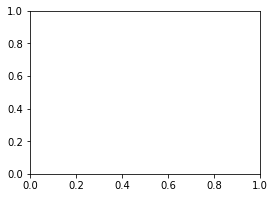

In [18]:
#Distributions for Full dataset
plots_size = (14,3)
plt.figure(1, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_full['Original Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Original Rating')
original.set_xlabel('Scores Full')
original.set_ylabel('Reviews Full')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_full['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Full')
predicted.set_ylabel('Reviews Full')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_full['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Full')
predicted_sharpen.set_ylabel('Reviews Full')

#Distributions for Medium dataset
plots_size = (14,3)
plt.figure(2, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_medium['Original Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Original Rating')
original.set_xlabel('Scores Medium')
original.set_ylabel('Reviews Medium')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_medium['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Medium')
predicted.set_ylabel('Reviews Medium')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_medium['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Medium')
predicted_sharpen.set_ylabel('Reviews Medium')

#Distributions for Small dataset
plots_size = (14,3)
plt.figure(3, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_small['Original Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Original Rating')
original.set_xlabel('Scores Small')
original.set_ylabel('Reviews Small')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_small['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Small')
predicted.set_ylabel('Reviews Small')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_small['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Small')
predicted_sharpen.set_ylabel('Reviews Small')

plt.show()